### Bar Samplizing

In [1]:
from FinancialMachineLearning.barsampling.core import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

txt파일형식의 고빈도데이터를 csv파일 형태로 저장해두자

In [3]:
data = pd.read_parquet('../../Data/IVEfuture.parquet')

In [4]:
data['date'] = pd.to_datetime(data['date'])

In [5]:
bar = StandardBarFeatures(file_path_or_df = data)

### 1. Standard Bar

어떤 바 구성 기법은 대다수의 데이터 업체가 여러 API를 제공할 정도로 금융 분야에 있어 매우 보편적이다. 이러한 기법의 목적은 비규칙적인 주기로 얻어진 계열 관측 자료를 규칙적 표본 추출로부터 도출된 균질 계열을 변환하는 것이다.

#### 1.1 Time Bar

Time Bar는 고정된 시간 간격으로 정보를 표본 추출해 생성한다. 예를 들어 매 분 자료를 얻는 식이 된다. 이때 얻게 되는 자료는 대개 다음과 같다.

- Time Stamp
- Volume Weighted Average Price
- Open Price
- Close Price
- High Price
- Low Price
- Volume weights

Time Bar는 아마도 전문가나 학자 사이에서 가장 보편적인 것이겠지만, 두 가지 이유 때문에 사용을 자제하는 것이 좋다. 첫째, 시장은 정보를 일정한 시간 간격으로 처리하지 않는다. 금융 시장이 열린 직후 한 시간은 정오 때의 한 시간보다 훨씬 거래가 활발하다. 사람은 생물학적 존재이기 때문에 낮 시간 주기에 맞춰 생활하는 것이 자연스럽다. 그러나 오늘날의 금융 시장은 사람의 감시를 그다지 필요로 하지 않는 알고리즘에 의해 운영되므로, 시간적 구간보다는 CPU의 처리 주기가 훨씬 더 중요하다. 이는 Time Bar가 거래가 적을 때 샘플을 과도하게 추출하는 반면, 거래가 활발할 때는 샘플을 과소하게 추출함을 의미한다. 둘째, 시간에 따라 추출된 시계열 자료는 종종 좋지 않은 통계적 성질을 보이는데, 그 예로는 Serial Correlation, Heteroscedasticity, non-normality등이 있다(Easley, Lopez de Prado & O'Hara, 2012). GARCH 모형은 음성확한 표본 추출에 따른 이분산성을 어느 정도 해결하고자 개발된 것이다. 뒤에서 설명하지만, 샘플을 거래 활동량에 종속되게 형성하면 이러한 문제를 우선 해결할 수 있다.

#### 1.2 Tick Bar

Tick Bar의 기본적인 아이디어는 간단하다. 앞서 열거한 변수들을 사전에 정해 둔 거래 건수가 발생할 때마다 추출하는 것이다. 이렇게 하면 정보의 도착과 표본 추출을 동기화할 수 있다.

In [6]:
tick = bar.tick_bar(threshold = 600)
tick

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2009-09-28 10:24:04,600,50.790,51.2900,50.7100,51.250,191164,130023,600,9.780588e+06
1,2009-09-28 11:51:42,1200,51.250,51.4360,51.2300,51.430,176724,98400,600,9.072843e+06
2,2009-09-28 14:09:28,1800,51.430,51.6000,51.4060,51.440,157179,89990,600,8.090282e+06
3,2009-09-28 15:09:12,2400,51.440,51.5300,51.3936,51.430,205400,69674,600,1.056945e+07
4,2009-09-29 10:03:18,3000,51.430,51.9600,51.3790,51.520,149219,86863,600,7.700035e+06
...,...,...,...,...,...,...,...,...,...,...
18813,2024-03-28 09:56:43,11288400,185.420,186.8400,185.3801,186.310,136707,49847,600,2.544512e+07
18814,2024-03-28 12:07:45,11289000,186.330,186.7900,186.3200,186.779,139200,61683,600,2.597304e+07
18815,2024-03-28 13:50:23,11289600,186.765,186.8050,186.5750,186.755,94342,48459,600,1.761582e+07
18816,2024-03-28 15:00:52,11290200,186.750,187.0200,186.6950,186.980,116615,62116,600,2.178476e+07


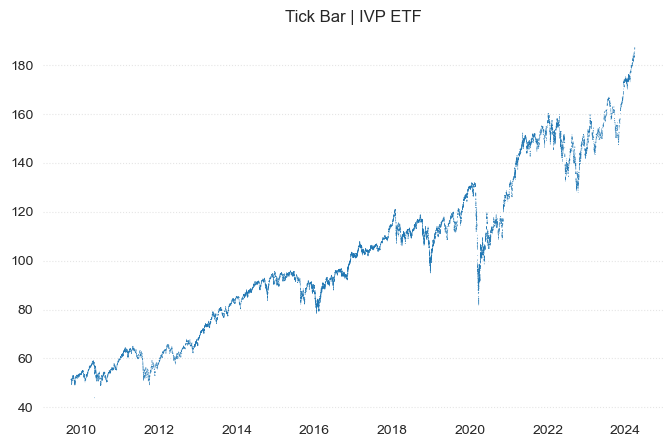

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(tick['date_time'], tick['close'], marker = '.', s = 1, edgecolor = 'none')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Tick Bar | IVP ETF')
plt.show()

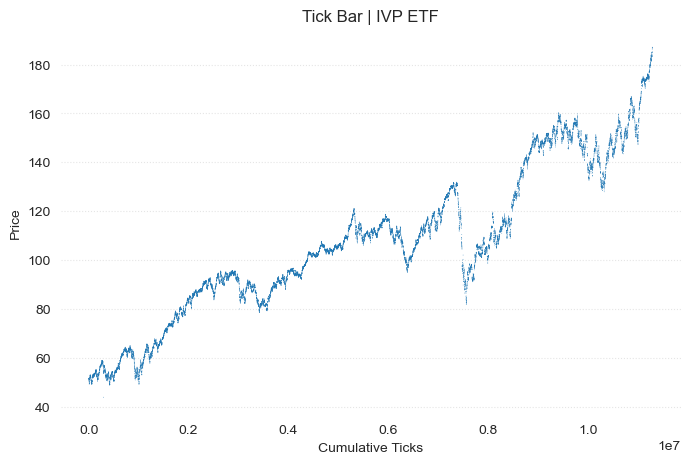

In [31]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    tick['cum_ticks'].cumsum(), 
    tick['close'], 
    marker = '.', 
    s = 1, 
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Ticks')
plt.ylabel('Price')
plt.title('Tick Bar | IVP ETF')
plt.show()

In [9]:
#tick.to_parquet('../../Data/tick_IVEfuture.parquet')

#### 1.3 Volume Bar

Tick Bar의 문제점 중 하나는 주문의 파편성으로 틱 수가 임의적이라는 점이다. 예를 들어, 대기 중인 주문의 크기가 10이라 가정해 보자. 만약 10 lot를 사면 그 거래는 하나의 틱으로 기록될 것이다. 이와 반대로, 크기가 1인 주문 10개가 쌓여 있다면 거래는 10개의 개별 거래로 기록될 것이다. 게다가 가격 매치 엔진 프로토콜은 운영의 편의성을 위해 하나의 주문 체결을 다수의 인위적인 부분 주문 체결로 분리할 수 있다. Volume Bar는 이러한 문제를 미리 정의된 단위의 증권 거래가 일어날 때마다 표본 추출해 해결했다. 예를 들어, Tick의 개수가 몇 개든 상관하지 않고 단지 선물 계약이 1000단위로 거래될 때마다 가격 표본 추출을 할 수 있다.

In [10]:
volume = bar.volume_bar(threshold = 10000)
volume

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2009-09-28 09:41:53,48,50.7900,50.8500,50.7100,50.8400,10144,5364,48,5.152712e+05
1,2009-09-28 09:46:35,81,50.8500,51.0700,50.8300,51.0700,11900,9900,33,6.068960e+05
2,2009-09-28 09:47:25,106,51.0700,51.0700,51.0500,51.0600,10000,9900,25,5.106420e+05
3,2009-09-28 09:53:47,148,51.0600,51.1500,51.0600,51.1300,10824,8174,42,5.532435e+05
4,2009-09-28 09:54:34,180,51.1300,51.1400,51.1300,51.1300,10851,4451,32,5.548561e+05
...,...,...,...,...,...,...,...,...,...,...
230088,2024-03-28 15:58:21,11290844,187.0200,187.0800,186.9200,187.0400,10607,4840,68,1.983940e+06
230089,2024-03-28 15:59:32,11290915,187.0400,187.1000,186.9700,187.0400,10072,2778,71,1.883893e+06
230090,2024-03-28 15:59:53,11290999,187.0600,187.0650,186.8500,186.8500,10047,3600,84,1.878318e+06
230091,2024-03-28 16:00:00,11291062,186.8500,186.8900,186.7700,186.8100,30020,22083,63,5.608132e+06


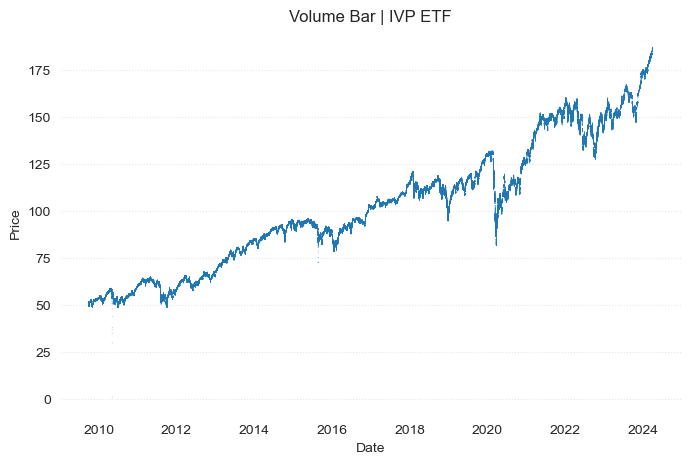

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(volume['date_time'], volume['close'], marker = '.', s = 1, edgecolor = 'none')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Volume Bar | IVP ETF')
plt.show()

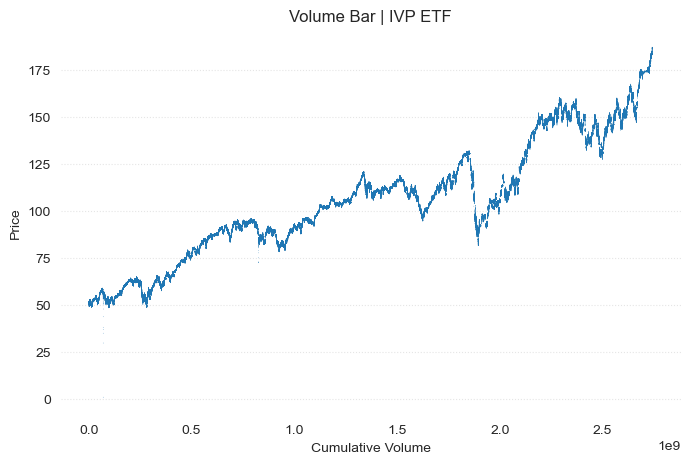

In [16]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    volume['volume'].cumsum(),
    volume['close'],
    marker = '.', 
    s = 1, 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Volume Bar | IVP ETF')
plt.show()

In [58]:
#volume.to_csv('../../Data/volume_IVEfuture.csv', index = False)

#### 1.4 Dollar Value Bar

Dollar Bar는 사전에 정해 둔 market value가 거래될 때마다 관측값을 표본 추출하는 것이다. Dollar Bar를 활용하는 이론적 근거를 몇 가지 사례와 함께 알아보자. 첫째, 특정 기간 동안 100% 가격이 상승한 주식을 분석하고자 한다. 해당 기간 말에 그 주식을 1000달러 매도하려 한다면 해당 기간 초에 1000달러 가치였던 주식을 절반만 매도하면 된다. 다시 말해, 거래된 주식 수는 실제 거래된 가치의 함수이다. 그러므로 틱이나 거래량보다는 거래된 대금으로 표본 추출하는 것이 더 합리적이며 특히 큰 가격 변동을 분석하는 경우 더욱 그렇다. 이 점은 경험적으로도 증명할 수 있다. 주어진 바의 크기로 E-mini S&P 500 선물의 틱 바와 거래량 바를 계산해 보면 일별 바의 개수는 해마다 상당히 변동이 심하다. 하지만, 고정된 크기의 일별 거래대금 바로 계산하면 연간 변동의 범위와 속도는 감소할 것이다. 아래의 그림은 고정된 바 크기로 틱, 거래량, 거래대금 추출법을 적용할 때 지수가중 평균된 일평균 바 개수를 그려본 것이다.

In [17]:
dollar = bar.dollar_bar()
dollar

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2009-09-28 09:46:34,80,50.7900,51.0700,50.7100,51.0700,20044,13264,80,1.020027e+06
1,2009-09-28 09:52:47,142,51.0700,51.1480,51.0500,51.1300,21024,19774,62,1.073986e+06
2,2009-09-28 09:54:38,201,51.1400,51.1500,51.1290,51.1300,19951,6951,59,1.020145e+06
3,2009-09-28 09:55:26,243,51.1300,51.1500,51.1300,51.1400,19652,18052,42,1.004999e+06
4,2009-09-28 10:02:48,339,51.1400,51.2600,51.0800,51.2500,19943,11354,96,1.020512e+06
...,...,...,...,...,...,...,...,...,...,...
236729,2024-03-28 15:59:53,11290981,187.0200,187.0200,186.8700,186.8900,5399,1400,46,1.009237e+06
236730,2024-03-28 15:59:56,11291032,186.8900,186.8900,186.8200,186.8200,5908,1808,51,1.103962e+06
236731,2024-03-28 15:59:59,11291059,186.8200,186.8241,186.7700,186.7700,5488,751,27,1.025128e+06
236732,2024-03-28 16:00:00,11291062,186.7700,186.8100,186.7700,186.8100,20424,20224,3,3.815399e+06


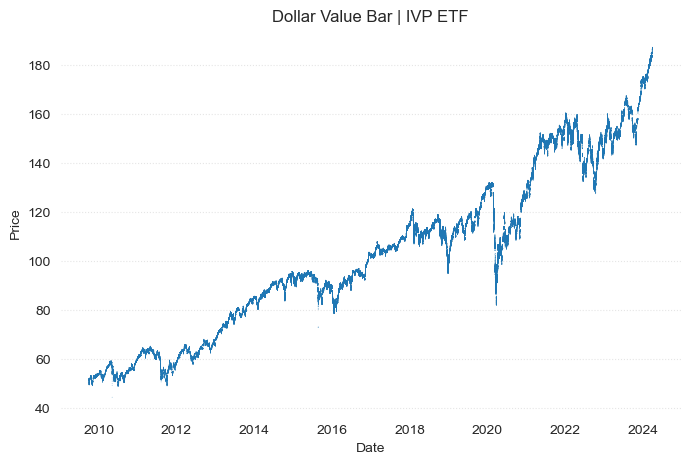

In [32]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    dollar['date_time'], 
    dollar['close'],
    marker = '.', 
    s = 1, 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dollar Value Bar | IVP ETF')
plt.show()

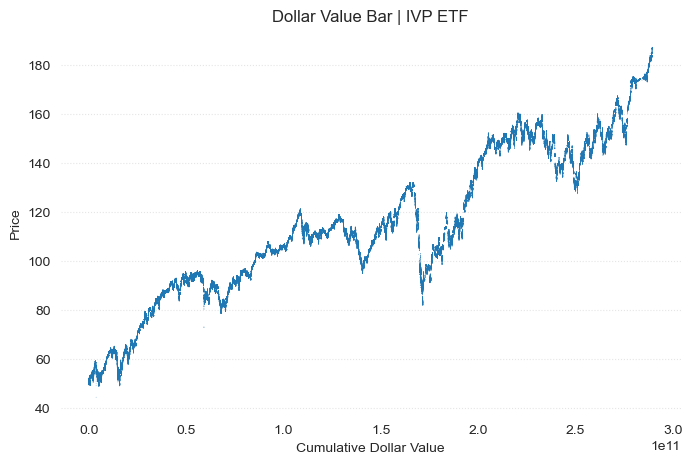

In [23]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    dollar['cum_dollar_value'].cumsum(), 
    dollar['close'],
    marker = '.', 
    s = 1, 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Dollar Value')
plt.ylabel('Price')
plt.title('Dollar Value Bar | IVP ETF')
plt.show()

In [24]:
#dollar.to_csv('../../Data/dollar_IVEfuture.csv', index = False)

#### Bar Counting

In [25]:
data.index = data['date']
tick.index = tick['date_time']
volume.index = volume['date_time']
dollar.index = dollar['date_time']

In [26]:
time_count = data['price'].resample('W', label = 'right').count()
tick_count = tick['close'].resample('W', label = 'right').count()
volume_count = volume['close'].resample('W', label = 'right').count()
dollar_count = dollar['close'].resample('W', label = 'right').count()

In [27]:
count_df = pd.concat([time_count, tick_count, volume_count, dollar_count], axis = 1)
count_df.columns = ['time', 'tick', 'volume', 'dollar']
count_df

,time,tick,volume,dollar
2009-10-04,14151,23,318,165
2009-10-11,8792,15,196,103
2009-10-18,9727,16,200,106
2009-10-25,12453,21,249,133
2009-11-01,13525,22,303,155
...,...,...,...,...
2024-03-03,8466,14,166,292
2024-03-10,11133,19,202,357
2024-03-17,13568,23,229,399
2024-03-24,8705,14,162,283


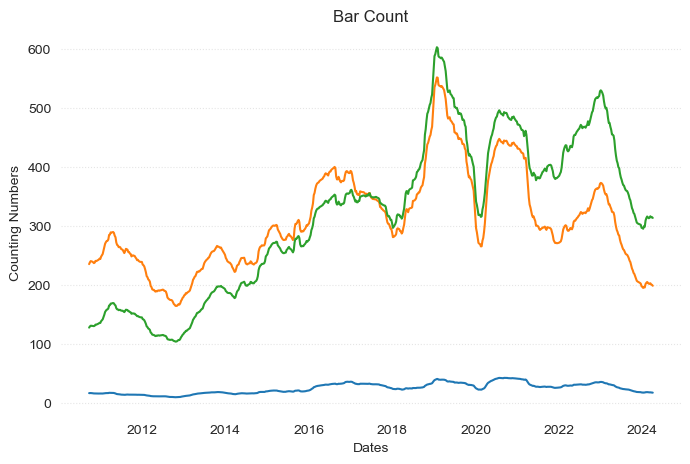

In [29]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    count_df.iloc[:,1:].rolling(window = 52).mean()
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Dates')
plt.ylabel('Counting Numbers')
plt.title('Bar Count')
plt.show()